In [1]:
import sys
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install tensorflow
!{sys.executable} -m pip install imblearn
!{sys.executable} -m pip install sklearn
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install xgboost
!{sys.executable} -m pip install pyod
!{sys.executable} -m pip install lightgbm
!{sys.executable} -m pip install catboost 
!{sys.executable} -m pip install plotly 
!{sys.executable} -m pip install seaborn 
!{sys.executable} -m pip install nltk 

In [1]:
import glob
import time
import pandas as pd
import numpy as np
# from xml.dom import minidom
from nltk import ngrams
from nltk.tokenize import sent_tokenize
import nltk
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve,roc_auc_score, precision_recall_curve, average_precision_score
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import csv
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score


import re
from nltk.corpus import stopwords
from nltk.tokenize import ToktokTokenizer
from nltk.stem.snowball import SnowballStemmer

import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\monju\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
df = pd.read_csv("Dataset/posts.csv")
df.head()

,Id,PostTypeId,AcceptedAnswerId,CreationDate,Days,Score,ViewCount,Body,LastActivityDate,Title,Tags,AnswerCount,CommentCount,Class,currentDate
0,26218391,1,NaN,06-10-14 14:26,1,1,111,<p>I'm currently starting a new project where ...,07-10-14 7:48,Testing reusable components / services across ...,<testing><components><agile><platform><microse...,1,0,0,23-10-20
1,26247474,1,NaN,08-10-14 0:38,1,0,1484,<p>I am involved in the design of a service th...,08-10-14 8:52,Is Apache Camel irrelevant when Spring Cloud i...,<apache-camel><mule><spring-boot><microservice...,1,0,0,23-10-20
2,26331854,1,NaN,13-10-14 1:45,1,27,52135,<p>How to build micro service oriented applica...,28-05-17 20:53,Micro services and .NET,<.net><microservices>,5,1,0,23-10-20
3,26491425,1,NaN,21-10-14 16:16,1,8,1439,<p>In the 12 Factor article on Port Binding\n<...,18-12-16 19:30,Why should a 12 Factor app be self contained?,<java><paas><12factor><microservices>,2,0,0,23-10-20
4,26529567,1,NaN,23-10-14 13:46,1,4,1088,<p>Usually when you have a monolithic applicat...,23-10-15 15:25,What are the strategies available for doing pa...,<filter><pagination><filtering><paging><micros...,1,0,0,23-10-20


Text(0.5, 1.0, 'Ratio of missing values per columns')

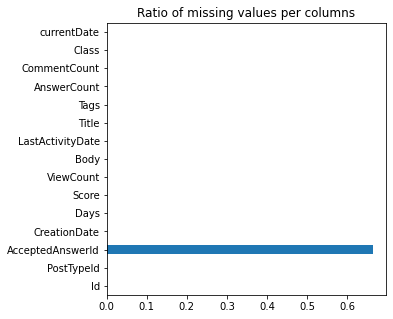

In [3]:
plt.figure(figsize=(5, 5))
df.isnull().mean(axis=0).plot.barh()
plt.title("Ratio of missing values per columns")

In [4]:
tokenizer = ToktokTokenizer()
stemmer = SnowballStemmer('english')
stop_words = set(stopwords.words('english'))

In [5]:
def remove_html(text):
    # Remove html and convert to lowercase
    return re.sub(r"\<[^\>]\>", "", text).lower()

def remove_stopwords(text):    
    # tokenize the text
    words = tokenizer.tokenize(text)
    
    filtered = [w for w in words if not w in stop_words]
    return ' '.join(map(str, filtered))

def remove_punc(text):
    #tokenize
    tokens = tokenizer.tokenize(text)
    
    # remove punctuations from each token
    tokens = list(map(lambda token: re.sub(r"[^A-Za-z0-9]+", " ", token).strip(), tokens))
    
    # remove empty strings from tokens
    tokens = list(filter(lambda token: token, tokens))
    
    return ' '.join(map(str, tokens))

def stem_text(text):
    #tokenize
    tokens = tokenizer.tokenize(text)
    
    # stem each token
    tokens = list(map(lambda token: stemmer.stem(token), tokens))
    
    return ' '.join(map(str, tokens))

In [6]:
%%time
# apply preprocessing to title and body
## Remove puntuation and preposition from text(title and body)
df['Title'] = df['Title'].apply(lambda x: remove_html(x))
df['Title'] = df['Title'].apply(lambda x: remove_stopwords(x))
df['Title'] = df['Title'].apply(lambda x: remove_punc(x))
df['Title'] = df['Title'].apply(lambda x: stem_text(x))

Wall time: 1.21 s


In [7]:
%%time
# apply preprocessing to title and body
df['Body'] = df['Body'].apply(lambda x: remove_html(x))
df['Body'] = df['Body'].apply(lambda x: remove_stopwords(x))
df['Body'] = df['Body'].apply(lambda x: remove_punc(x))
df['Body'] = df['Body'].apply(lambda x: stem_text(x))

Wall time: 19.2 s


In [8]:
vectorizer_title = TfidfVectorizer(analyzer = 'word',
                                       min_df=0.0,
                                       max_df = 1.0,
                                       strip_accents = None,
                                       encoding = 'utf-8', 
                                       preprocessor=None,
                                       token_pattern=r"(?u)\S\S+", # Need to repeat token pattern
                                       max_features=4)

In [9]:
vectorizer_body = TfidfVectorizer(
                                    analyzer = 'word', 
                                    strip_accents = None, 
                                    encoding = 'utf-8', 
                                    preprocessor=None, 
                                    max_features=10)

In [10]:
vectorizer = CountVectorizer( min_df=2, max_df=0.7, stop_words=stopwords.words('english'))
 
texttile = vectorizer.fit_transform(df['Title'].values.astype('U')).toarray()
textbody = vectorizer.fit_transform(df['Body'].values.astype('U')).toarray()
# print(posts)

texttile=pd.DataFrame(texttile)

textbody=pd.DataFrame(textbody)


df=pd.concat([df,texttile,textbody],axis=1)

In [11]:
## Remove less important features
df = df.drop(['Body', 'Title','Tags','CreationDate','LastActivityDate','currentDate','AcceptedAnswerId'],axis = 1,inplace=False)

## Scalling column using RobustScaler
df['Id'] = RobustScaler().fit_transform(df['Id'].values.reshape(-1,1))
df['PostTypeId'] = RobustScaler().fit_transform(df['PostTypeId'].values.reshape(-1,1))
#df['creationDate'] = RobustScaler().fit_transform(df['creationDate'].values.reshape(-1,1))
df['Days'] = RobustScaler().fit_transform(df['Days'].values.reshape(-1,1))
df['Score'] = RobustScaler().fit_transform(df['Score'].values.reshape(-1,1))
df['ViewCount'] = RobustScaler().fit_transform(df['ViewCount'].values.reshape(-1,1))
#df['LastActivityDate'] = RobustScaler().fit_transform(df['LastActivityDate'].values.reshape(-1,1))
#df['Tags'] = RobustScaler().fit_transform(df['Tags'].values.reshape(-1,1))
df['AnswerCount'] = RobustScaler().fit_transform(df['AnswerCount'].values.reshape(-1,1))
df['CommentCount'] = RobustScaler().fit_transform(df['CommentCount'].values.reshape(-1,1))

In [12]:
## training and testing dataset devide
# Class count
# Define the prep_data function to extrac features 
def prep_data(df):
    X = df.drop(['Class'],axis=1, inplace=False)  
    X = np.array(X).astype(np.float)
    y = df[['Class']]  
    y = np.array(y).astype(np.float)
    return X,y

In [13]:
df

,Id,PostTypeId,Days,Score,ViewCount,AnswerCount,CommentCount,Class,0,1,...,10085,10086,10087,10088,10089,10090,10091,10092,10093,10094
0,-1.953916,0.0,0.0,0.0,-0.124792,0.0,0.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,-1.951840,0.0,0.0,-0.5,2.159734,0.0,0.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,-1.945817,0.0,0.0,13.0,86.437604,4.0,0.5,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,-1.934427,0.0,0.0,3.5,2.084859,1.0,0.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,-1.931705,0.0,0.0,1.5,1.500832,0.0,0.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5973,0.714789,0.0,0.0,0.0,-0.074875,0.0,0.0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
5974,0.715058,0.0,0.0,-0.5,-0.153078,0.0,2.5,1,0,0,...,0,0,0,0,0,0,0,0,0,0
5975,0.715061,0.0,0.0,-0.5,-0.277870,-1.0,1.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5976,0.715074,0.0,0.0,-0.5,-0.214642,0.0,1.0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
# Create X and y from the prep_data function 
X, y = prep_data(df)
y= y.astype(np.int64)

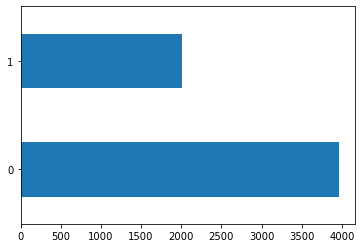

In [49]:
df.Class.value_counts().plot(kind='barh')

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.6, random_state=None)

In [36]:
# ****** LogisticRegression Accuration test
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

C:\tools\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\tools\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [37]:
# confusion matrix
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[1739,  618],
       [ 768,  462]], dtype=int64)

Text(0.5, 257.44, 'Predicted label')

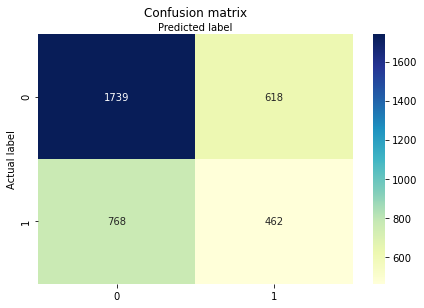

In [38]:
import seaborn as sns
from sklearn import metrics

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

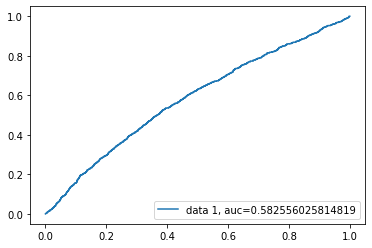

In [39]:
y_pred_proba = model.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [40]:
# instantiate classifier with default hyperparameters
clf = SVC(probability=True)
clf.fit(X_train, y_train)
y_predsvm = clf.predict(X_test)


C:\tools\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Text(0.5, 257.44, 'Predicted label')

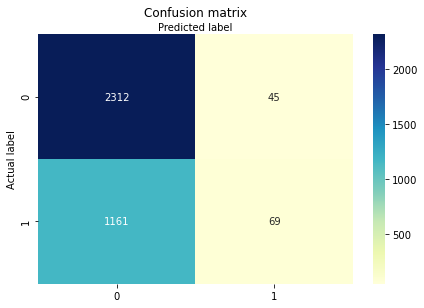

In [41]:
import seaborn as sns
from sklearn import metrics

cnf_matrix = metrics.confusion_matrix(y_test, y_predsvm)
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

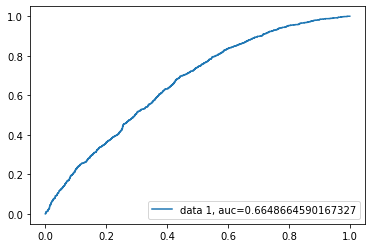

In [42]:
y_pred_proba = clf.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [43]:
## Random forest classifier algorithm
#Create a Gaussian Classifier
rfclf=RandomForestClassifier(n_estimators=100)
#Train the model using the training sets y_pred=clf.predict(X_test)
rfclf.fit(X_train, y_train)
y_pred_rf=rfclf.predict(X_test)
## Random Forest Evaluation
rf_accuracy = accuracy_score(y_test, y_pred_rf)
rf_precision= precision_score(y_test, y_pred_rf)
rf_recall = recall_score(y_test, y_pred_rf)
rf_f1 = f1_score(y_test, y_pred_rf)


<ipython-input-43-e77ce5ca8c56>:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfclf.fit(X_train, y_train)


Text(0.5, 257.44, 'Predicted label')

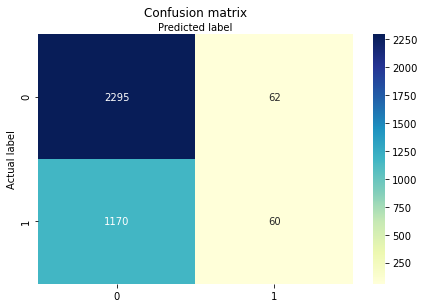

In [44]:
import seaborn as sns
from sklearn import metrics

cnf_matrix = metrics.confusion_matrix(y_test, y_pred_rf)
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

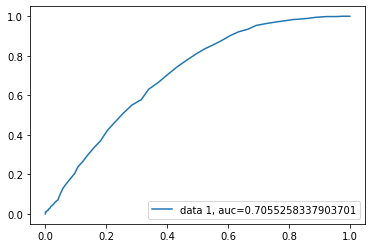

In [45]:
y_pred_proba = rfclf.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [46]:
## Decision Tree Classifier algorithm
# Create Decision Tree classifer object
dtclf = DecisionTreeClassifier()
# Train Decision Tree Classifer
dtclf = dtclf.fit(X_train,y_train)
#Predict the response for test dataset
y_pred_dt = dtclf.predict(X_test)

## Decision Tree Evaluation
dt_accuracy = accuracy_score(y_test, y_pred_dt)
dt_precision= precision_score(y_test, y_pred_dt)
dt_recall = recall_score(y_test, y_pred_dt)
dt_f1 = f1_score(y_test, y_pred_dt)

Text(0.5, 257.44, 'Predicted label')

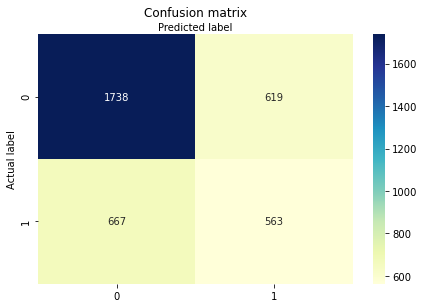

In [47]:
import seaborn as sns
from sklearn import metrics

cnf_matrix = metrics.confusion_matrix(y_test, y_pred_dt)
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

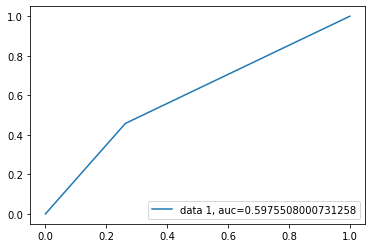

In [48]:
y_pred_proba = dtclf.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()